### Estimation of obesity levels based on eating habits and physical condition

In [1]:
import pandas as pd
import numpy as np
import sklearn as skl
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
import statistics 
from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import StratifiedKFold,cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [5]:
df= pd.read_csv(r'C:\Users\Maedeh\Downloads\ObesityDataSet_raw_and_data_sinthetic.csv')

In [6]:
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


The dataset contains 16 variables. 15 features:
Gender
Age
Height
Weight
Family History with Overweight
Attributes related with eating habits (6)
Attributes related with the physical condition (4)
1 target:
NObeyesdad, renamed NObesity
Another revelant information is that most of these variables are category, except for Age, Height and Weight.

we want to classify individuals according to their obesity level which will be named: NObesity
There are 7 variables:
Insufficient_Weight/
Normal_Weight/
Overweight_Level_I/
Overweight_Level_II/
Obesity_Type_I/
Obesity_Type_II/
Obesity_Type_III

### Data Cleaning

In [7]:
df_clean = df.dropna()
print(df_clean.shape, df.shape)

(2111, 17) (2111, 17)


#### there is no missing value in our dataset!

We will check if we have outliers for non-categorical variables(Age, Height and Weight) or not. The study has been done with subjects between 14 and 61, so there is not a problem with it.

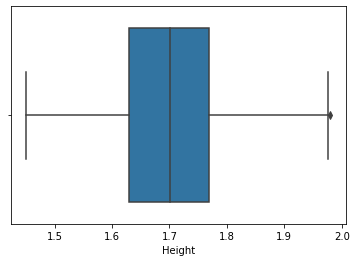

In [8]:
sns.boxplot(x=df['Height'])

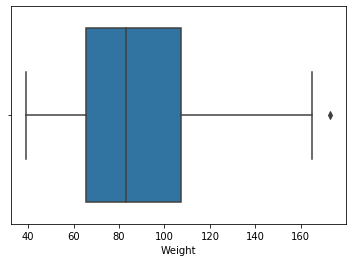

In [9]:
sns.boxplot(x=df['Weight'])

we will exclude the extreme values by using quantile values.

In [10]:
df_categorized = df.copy()

In [11]:
q1, q2 = df_categorized["Height"].quantile(q=0.25), df_categorized["Height"].quantile(q=0.75)
q3, q4 = df_categorized["Weight"].quantile(q=0.25), df_categorized["Weight"].quantile(q=0.75)

IQR1, IQR2 = q2-q1, q4-q3

#Height selection
df_categorized = df_categorized[df_categorized["Height"] >  q1 - 1.5*IQR1]
df_categorized = df_categorized[df_categorized["Height"] <  q2 + 1.5*IQR1]

#Weight selection
df_categorized = df_categorized[df_categorized["Weight"] >  q3 - 1.5*IQR2]
df_categorized = df_categorized[df_categorized["Weight"] <  q4 + 1.5*IQR2]

df_categorized.shape

(2109, 17)

3 lines were deleted.

In [12]:
df.describe().T.style.bar(subset=['mean'], color='#606ff2').background_gradient(subset=['std'], cmap='Blues').background_gradient(subset=['50%'], cmap='Blues')

,count,mean,std,min,25%,50%,75%,max
Age,2111,24.3126,6.34597,14,19.9472,22.7779,26,61
Height,2111,1.70168,0.0933048,1.45,1.63,1.7005,1.76846,1.98
Weight,2111,86.5861,26.1912,39,65.4733,83,107.431,173
FCVC,2111,2.41904,0.533927,1,2,2.3855,3,3
NCP,2111,2.68563,0.778039,1,2.65874,3,3,4
CH2O,2111,2.00801,0.612953,1,1.58481,2,2.47742,3
FAF,2111,1.0103,0.850592,0,0.124505,1,1.66668,3
TUE,2111,0.657866,0.608927,0,0,0.62535,1,2


In [13]:
target = pd.DataFrame(df_categorized, columns = ['NObeyesdad'])

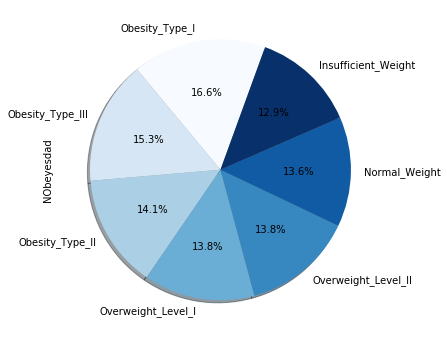

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(18, 6))
target['NObeyesdad'].value_counts().plot.pie(autopct='%1.1f%%',shadow=True, cmap="Blues", startangle=70)

In [15]:
list_var = ['Gender','family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
for x in list_var:
    print(df_categorized[x].unique())

['Female' 'Male']
['yes' 'no']
['no' 'yes']
['Sometimes' 'Frequently' 'Always' 'no']
['no' 'yes']
['no' 'yes']
['no' 'Sometimes' 'Frequently' 'Always']
['Public_Transportation' 'Walking' 'Automobile' 'Motorbike' 'Bike']


In [16]:
dict_Gender = {'Female' : 0, 'Male' : 1}
dict_family_history_with_overweight = {'no' : 0, 'yes' : 1}
dict_FAVC = {'no' : 0, 'yes' : 1}
dict_CAEC = {'no' : 0, 'Sometimes' : 1, 'Frequently' : 2, 'Always' : 3}
dict_SMOKE = {'no' : 0, 'yes' : 1}
dict_SCC = {'no' : 0, 'yes' : 1}
dict_CALC = {'no' : 0, 'Sometimes' : 1, 'Frequently' : 2, 'Always' : 3}
dict_MTRANS = {'Public_Transportation' : 0, 'Walking' : 1, 'Automobile' : 2, 'Motorbike' : 3, 'Bike' : 4}
dict_NObeyesdad = {'Normal_Weight' : 0, 'Overweight_Level_I' : 1, 'Overweight_Level_II' : 2, 'Obesity_Type_I' : 3, 'Insufficient_Weight' : 4, 'Obesity_Type_II' : 5, 'Obesity_Type_III' : 6,}

In [17]:
for x in list_var:
    exec("df_categorized['"+ x +"'] = df_categorized['"+ x +"'].replace(dict_"+ x +")") #transformation for each string variable

df_categorized.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,21.0,1.62,64.0,1,0,2.0,3.0,1,0,2.0,0,0.0,1.0,0,0,Normal_Weight
1,0,21.0,1.52,56.0,1,0,3.0,3.0,1,1,3.0,1,3.0,0.0,1,0,Normal_Weight
2,1,23.0,1.80,77.0,1,0,2.0,3.0,1,0,2.0,0,2.0,1.0,2,0,Normal_Weight
3,1,27.0,1.80,87.0,0,0,3.0,3.0,1,0,2.0,0,2.0,0.0,2,1,Overweight_Level_I
4,1,22.0,1.78,89.8,0,0,2.0,1.0,1,0,2.0,0,0.0,0.0,1,0,Overweight_Level_II


### Data Processing

In [18]:
df_features = df_categorized.drop(columns = 'NObeyesdad')

In [19]:
scaler = preprocessing.StandardScaler().fit(df_features)
df_scaled = pd.DataFrame(scaler.transform(df_features))
df_scaled['NObesity'] = df['NObeyesdad']
df_scaled.columns = df.columns.to_list()
df_scaled.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,-1.010966,-0.522851,-0.875432,-0.862561,0.472565,-2.75829,-0.784838,0.404376,-0.29881,-0.145971,-0.012314,-0.218380,-1.187312,0.562347,-1.418188,-0.562843,Normal_Weight
1,-1.010966,-0.522851,-1.950036,-1.168884,0.472565,-2.75829,1.088434,0.404376,-0.29881,6.850680,1.619759,4.579165,2.339939,-1.079742,0.521474,-0.562843,Normal_Weight
2,0.989153,-0.207656,1.058855,-0.364787,0.472565,-2.75829,-0.784838,0.404376,-0.29881,-0.145971,-0.012314,-0.218380,1.164189,0.562347,2.461135,-0.562843,Normal_Weight
3,0.989153,0.422733,1.058855,0.018116,-2.116110,-2.75829,1.088434,0.404376,-0.29881,-0.145971,-0.012314,-0.218380,1.164189,-1.079742,2.461135,0.588501,Overweight_Level_I
4,0.989153,-0.365253,0.843934,0.125329,-2.116110,-2.75829,-0.784838,-2.165781,-0.29881,-0.145971,-0.012314,-0.218380,-1.187312,-1.079742,0.521474,-0.562843,Overweight_Level_II


In [20]:
df_scaled_features = df_scaled.drop(columns = 'NObeyesdad')
X_train, X_test, Y_train, Y_test = train_test_split(df_scaled_features, df_scaled['NObeyesdad'], test_size=0.33)

### KNN

In [21]:
%%time
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train,Y_train).predict(X_test)
pred_knn1 = knn1.predict(X_test)

Wall time: 83.8 ms


In [22]:
acc_knn1 = cross_val_score(knn1, X_test, Y_test, cv=3, scoring='accuracy')
acc_knn1
print(acc_knn1.mean())
print(acc_knn1.std())

0.7457507357432395
0.020202690354696014


In [23]:
precision_knn1 = cross_val_score(knn1, X_test, Y_test, cv=3, scoring='precision_macro')
precision_knn1
print(precision_knn1.mean())
print(precision_knn1.std())

0.7298375229165862
0.02835910239433468


In [24]:
recall_knn1 = cross_val_score(knn1, X_test, Y_test, cv=3, scoring='recall_macro')
recall_knn1
print(recall_knn1.mean())
print(recall_knn1.std())

0.7404015297754145
0.022339268352566534


In [25]:
f1_knn1 = cross_val_score(knn1, X_test, Y_test, cv=3, scoring='f1_macro')
f1_knn1
print(f1_knn1.mean())
print(f1_knn1.std())

0.7269488792059239
0.027531420081983032


In [26]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(Y_test, pred_knn1))
print(classification_report(Y_test, pred_knn1))

[[81  8  1  0  0  5  1]
 [12 36  6  2  1 15 17]
 [ 0  6 97  1  0  0 10]
 [ 0  1  1 98  0  0  0]
 [ 2  1  0  2 91  0  0]
 [ 4 11  6  0  0 74  8]
 [ 1  5  8  1  0  1 82]]
                     precision    recall  f1-score   support

Insufficient_Weight       0.81      0.84      0.83        96
      Normal_Weight       0.53      0.40      0.46        89
     Obesity_Type_I       0.82      0.85      0.83       114
    Obesity_Type_II       0.94      0.98      0.96       100
   Obesity_Type_III       0.99      0.95      0.97        96
 Overweight_Level_I       0.78      0.72      0.75       103
Overweight_Level_II       0.69      0.84      0.76        98

           accuracy                           0.80       696
          macro avg       0.79      0.80      0.79       696
       weighted avg       0.80      0.80      0.80       696



In [27]:
%%time
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(X_train,Y_train).predict(X_test)
pred_knn3 = knn3.predict(X_test)

Wall time: 88.8 ms


In [28]:
acc_knn3 = cross_val_score(knn3, X_test, Y_test, cv=3, scoring='accuracy')
acc_knn3
print(acc_knn3.mean())
print(acc_knn3.std())

0.6938633247478826
0.017196516667718556


In [29]:
precision_knn3 = cross_val_score(knn3, X_test, Y_test, cv=3, scoring='precision_macro')
precision_knn3
print(precision_knn3.mean())
print(precision_knn3.std())

0.6837673006833181
0.024801700195338176


In [30]:
recall_knn3 = cross_val_score(knn3, X_test, Y_test, cv=3, scoring='recall_macro')
recall_knn3
print(recall_knn3.mean())
print(recall_knn3.std())

0.6886263385902125
0.018497598104836376


In [31]:
f1_knn3 = cross_val_score(knn3, X_test, Y_test, cv=3, scoring='f1_macro')
f1_knn3
print(f1_knn3.mean())
print(f1_knn3.std())

0.6743803747173979
0.020513950059782623


In [32]:
print(confusion_matrix(Y_test, pred_knn3))
print(classification_report(Y_test, pred_knn3))

[[85  6  0  0  0  4  1]
 [20 36  8  2  0  8 15]
 [ 3  5 97  3  0  1  5]
 [ 0  2  0 98  0  0  0]
 [ 1  1  0  0 94  0  0]
 [ 7 14 10  0  0 70  2]
 [ 3  7  8  4  0  1 75]]
                     precision    recall  f1-score   support

Insufficient_Weight       0.71      0.89      0.79        96
      Normal_Weight       0.51      0.40      0.45        89
     Obesity_Type_I       0.79      0.85      0.82       114
    Obesity_Type_II       0.92      0.98      0.95       100
   Obesity_Type_III       1.00      0.98      0.99        96
 Overweight_Level_I       0.83      0.68      0.75       103
Overweight_Level_II       0.77      0.77      0.77        98

           accuracy                           0.80       696
          macro avg       0.79      0.79      0.79       696
       weighted avg       0.79      0.80      0.79       696



In [33]:
%%time
knn5 = KNeighborsClassifier(n_neighbors=5)
knn5.fit(X_train,Y_train).predict(X_test)
pred_knn5 = knn5.predict(X_test)

Wall time: 102 ms


In [34]:
acc_knn5 = cross_val_score(knn5, X_test, Y_test, cv=3, scoring='accuracy')
acc_knn5
print(acc_knn5.mean())
print(acc_knn5.std())

0.6896145944121956
0.013511753335305153


In [35]:
precision_knn5 = cross_val_score(knn5, X_test, Y_test, cv=3, scoring='precision_macro')
precision_knn5
print(precision_knn5.mean())
print(precision_knn5.std())

0.6851455279147585
0.018678977866147535


In [36]:
recall_knn5 = cross_val_score(knn5, X_test, Y_test, cv=3, scoring='recall_macro')
recall_knn5
print(recall_knn5.mean())
print(recall_knn5.std())

0.6854588592022631
0.015377408531142174


In [37]:
f1_knn5 = cross_val_score(knn5, X_test, Y_test, cv=3, scoring='f1_macro')
f1_knn5
print(f1_knn5.mean())
print(f1_knn5.std())

0.6696697348619965
0.015505801471887884


In [38]:
print(confusion_matrix(Y_test, pred_knn5))
print(classification_report(Y_test, pred_knn5))

[[87  6  0  0  0  3  0]
 [22 34  9  2  0  8 14]
 [ 2  5 98  4  0  1  4]
 [ 0  2  0 98  0  0  0]
 [ 1  1  0  0 94  0  0]
 [ 5 14 12  0  0 71  1]
 [ 1  6 10  8  0  6 67]]
                     precision    recall  f1-score   support

Insufficient_Weight       0.74      0.91      0.81        96
      Normal_Weight       0.50      0.38      0.43        89
     Obesity_Type_I       0.76      0.86      0.81       114
    Obesity_Type_II       0.88      0.98      0.92       100
   Obesity_Type_III       1.00      0.98      0.99        96
 Overweight_Level_I       0.80      0.69      0.74       103
Overweight_Level_II       0.78      0.68      0.73        98

           accuracy                           0.79       696
          macro avg       0.78      0.78      0.78       696
       weighted avg       0.78      0.79      0.78       696



In [39]:
error = []
for i in range(1, 10):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, Y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != Y_test))

Text(0, 0.5, 'Mean Error')

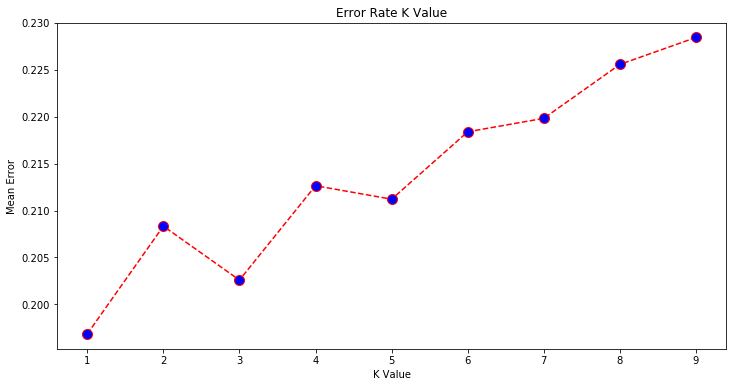

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 10), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

### Decision Tree

In [41]:
from sklearn.tree import DecisionTreeClassifier

In [42]:
%%time
from sklearn.metrics import accuracy_score
dtree1 = DecisionTreeClassifier(criterion='gini')
dtree1.fit(X_train, Y_train).predict(X_test)
pred_gini = dtree1.predict(X_test)

Wall time: 14 ms


In [43]:
acc_dtree1 = accuracy_score(Y_test, pred_gini)
acc_dtree1

0.860632183908046

In [44]:
acc_dtree1 = cross_val_score(dtree1, X_test, Y_test, cv=3, scoring='accuracy')
acc_dtree1
print(acc_dtree1.mean())
print(acc_dtree1.std())

0.8261288159339134
0.011538639704473972


In [45]:
precision_dtree1 = cross_val_score(dtree1, X_test, Y_test, cv=3, scoring='precision_macro')
precision_dtree1
print(precision_dtree1.mean())
print(precision_dtree1.std())

0.8163778202444675
0.006025610364312542


In [46]:
recall_dtree1 = cross_val_score(dtree1, X_test, Y_test, cv=3, scoring='recall_macro')
recall_dtree1
print(recall_dtree1.mean())
print(recall_dtree1.std())

0.8206806910191894
0.0135181130257771


In [47]:
f1_dtree1 = cross_val_score(dtree1, X_test, Y_test, cv=3, scoring='f1_macro')
f1_dtree1
print(f1_dtree1.mean())
print(f1_dtree1.std())

0.8203092621617162
0.018486562279976526


In [48]:
print(confusion_matrix(Y_test, pred_gini))
print(classification_report(Y_test, pred_gini))

[[83  9  1  0  0  0  3]
 [ 7 63  1  1  0 11  6]
 [ 3  3 97  1  0  2  8]
 [ 0  1  1 98  0  0  0]
 [ 2  1  0  1 92  0  0]
 [ 2 10  3  0  0 83  5]
 [ 1  4  7  1  0  2 83]]
                     precision    recall  f1-score   support

Insufficient_Weight       0.85      0.86      0.86        96
      Normal_Weight       0.69      0.71      0.70        89
     Obesity_Type_I       0.88      0.85      0.87       114
    Obesity_Type_II       0.96      0.98      0.97       100
   Obesity_Type_III       1.00      0.96      0.98        96
 Overweight_Level_I       0.85      0.81      0.83       103
Overweight_Level_II       0.79      0.85      0.82        98

           accuracy                           0.86       696
          macro avg       0.86      0.86      0.86       696
       weighted avg       0.86      0.86      0.86       696



In [49]:
%%time
dtree2 = DecisionTreeClassifier(criterion='entropy')
dtree2.fit(X_train, Y_train).predict(X_test)
pred_entropy = dtree2.predict(X_test)

Wall time: 21.9 ms


In [50]:
acc_dtree2 = cross_val_score(dtree2, X_test, Y_test, cv=3, scoring='accuracy')
acc_dtree2
print(acc_dtree2.mean())
print(acc_dtree2.std())

0.8146580555875907
0.009150755788011262


In [51]:
precision_dtree2 = cross_val_score(dtree2, X_test, Y_test, cv=3, scoring='precision_macro')
precision_dtree2
print(precision_dtree2.mean())
print(precision_dtree2.std())

0.8120136247352364
0.007346623955893313


In [52]:
recall_dtree2 = cross_val_score(dtree2, X_test, Y_test, cv=3, scoring='recall_macro')
recall_dtree2
print(recall_dtree2.mean())
print(recall_dtree2.std())

0.8239666354084944
0.011050653053102818


In [53]:
f1_dtree2 = cross_val_score(dtree2, X_test, Y_test, cv=3, scoring='f1_macro')
f1_dtree2
print(f1_dtree2.mean())
print(f1_dtree2.std())

0.8180469032448444
0.006329122379041995


In [54]:
print(confusion_matrix(Y_test, pred_entropy))
print(classification_report(Y_test, pred_entropy))

[[ 85   4   1   3   0   0   3]
 [  6  54   4   3   1  11  10]
 [  3   7 101   1   0   1   1]
 [  2   1   4  93   0   0   0]
 [  1   1   0   0  94   0   0]
 [  0  10   1   0   0  89   3]
 [  0  10   1   0   0   6  81]]
                     precision    recall  f1-score   support

Insufficient_Weight       0.88      0.89      0.88        96
      Normal_Weight       0.62      0.61      0.61        89
     Obesity_Type_I       0.90      0.89      0.89       114
    Obesity_Type_II       0.93      0.93      0.93       100
   Obesity_Type_III       0.99      0.98      0.98        96
 Overweight_Level_I       0.83      0.86      0.85       103
Overweight_Level_II       0.83      0.83      0.83        98

           accuracy                           0.86       696
          macro avg       0.85      0.85      0.85       696
       weighted avg       0.86      0.86      0.86       696



### SVM

In [55]:
%%time
# RBF
from sklearn.svm import SVC
svc_rbf = SVC(kernel='rbf',random_state = 0)
svc_rbf.fit(X_train,Y_train).predict(X_test)
pred_rbf = svc_rbf.predict(X_test)

Wall time: 119 ms


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [56]:
acc_rbf = cross_val_score(svc_rbf, X_test, Y_test, cv=3, scoring='accuracy')
acc_rbf
print(acc_rbf.mean())
print(acc_rbf.std())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.7557963539597723
0.018601317778979935


In [57]:
precision_rbf = cross_val_score(svc_rbf, X_test, Y_test, cv=3, scoring='precision_macro')
precision_rbf
print(precision_rbf.mean())
print(precision_rbf.std())

0.7531390818309788
0.020783796195513078


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [58]:
recall_rbf = cross_val_score(svc_rbf, X_test, Y_test, cv=3, scoring='recall_macro')
recall_rbf
print(recall_rbf.mean())
print(recall_rbf.std())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.7556281413736919
0.019136569419624827


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [59]:
f1_rbf = cross_val_score(svc_rbf, X_test, Y_test, cv=3, scoring='f1_macro')
f1_rbf
print(f1_rbf.mean())
print(f1_rbf.std())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.7526332652616438
0.01921849233852896


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [60]:
print(confusion_matrix(Y_test, pred_rbf))
print(classification_report(Y_test, pred_rbf))

[[ 81  14   0   0   0   1   0]
 [  7  59   2   0   0  12   9]
 [  0  10 100   2   0   1   1]
 [  0   4   0  95   0   0   1]
 [  1   1   0   0  94   0   0]
 [  1  16   6   0   0  74   6]
 [  0   8   6   1   0  11  72]]
                     precision    recall  f1-score   support

Insufficient_Weight       0.90      0.84      0.87        96
      Normal_Weight       0.53      0.66      0.59        89
     Obesity_Type_I       0.88      0.88      0.88       114
    Obesity_Type_II       0.97      0.95      0.96       100
   Obesity_Type_III       1.00      0.98      0.99        96
 Overweight_Level_I       0.75      0.72      0.73       103
Overweight_Level_II       0.81      0.73      0.77        98

           accuracy                           0.83       696
          macro avg       0.83      0.82      0.83       696
       weighted avg       0.84      0.83      0.83       696



In [61]:
%%time
#poly
svc_poly = svm.SVC(kernel='poly')
svc_poly.fit(X_train, Y_train).predict(X_test)
pred_poly= svc_poly.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Wall time: 97.7 ms


In [62]:
acc_poly = cross_val_score(svc_poly, X_test, Y_test, cv=3, scoring='accuracy')
acc_poly
print(acc_poly.mean())
print(acc_poly.std())

0.7009616986378605
0.03016384032636293


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [63]:
precision_poly = cross_val_score(svc_poly, X_test, Y_test, cv=3, scoring='precision_macro')
precision_poly
print(precision_poly.mean())
print(precision_poly.std())

0.7318852735335101
0.026740471014136295


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [64]:
recall_poly = cross_val_score(svc_poly, X_test, Y_test, cv=3, scoring='recall_macro')
recall_poly
print(recall_poly.mean())
print(recall_poly.std())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.6952525887437964
0.030096047609004733


In [65]:
f1_poly = cross_val_score(svc_poly, X_test, Y_test, cv=3, scoring='f1_macro')
f1_poly
print(f1_poly.mean())
print(f1_poly.std())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.6884932868991364
0.03000124396005371


In [66]:
print(confusion_matrix(Y_test, pred_entropy))
print(classification_report(Y_test, pred_entropy))

[[ 85   4   1   3   0   0   3]
 [  6  54   4   3   1  11  10]
 [  3   7 101   1   0   1   1]
 [  2   1   4  93   0   0   0]
 [  1   1   0   0  94   0   0]
 [  0  10   1   0   0  89   3]
 [  0  10   1   0   0   6  81]]
                     precision    recall  f1-score   support

Insufficient_Weight       0.88      0.89      0.88        96
      Normal_Weight       0.62      0.61      0.61        89
     Obesity_Type_I       0.90      0.89      0.89       114
    Obesity_Type_II       0.93      0.93      0.93       100
   Obesity_Type_III       0.99      0.98      0.98        96
 Overweight_Level_I       0.83      0.86      0.85       103
Overweight_Level_II       0.83      0.83      0.83        98

           accuracy                           0.86       696
          macro avg       0.85      0.85      0.85       696
       weighted avg       0.86      0.86      0.86       696



In [67]:
%%time
#sigmoid
svc_sigmoid = svm.SVC(kernel='sigmoid')
svc_sigmoid.fit(X_train, Y_train).predict(X_test)
pred_sigmoid= svc_sigmoid.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Wall time: 137 ms


In [68]:
acc_sig = cross_val_score(svc_sigmoid, X_test, Y_test, cv=3, scoring='accuracy')
acc_sig
print(acc_sig.mean())
print(acc_sig.std())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.600628959024761
0.01117281176518717


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [69]:
precision_sig = cross_val_score(svc_sigmoid, X_test, Y_test, cv=3, scoring='precision_macro')
precision_sig
print(precision_sig.mean())
print(precision_sig.std())

0.5877997723953041
0.018628793317890916


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [70]:
recall_sig = cross_val_score(svc_sigmoid, X_test, Y_test, cv=3, scoring='recall_macro')
recall_sig
print(recall_sig.mean())
print(recall_sig.std())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.5990562675876049
0.009898533183368325


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [71]:
f1_sig = cross_val_score(svc_sigmoid, X_test, Y_test, cv=3, scoring='f1_macro')
f1_sig
print(f1_sig.mean())
print(f1_sig.std())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.5879910071669845
0.01815050935956368


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [72]:
print(confusion_matrix(Y_test, pred_entropy))
print(classification_report(Y_test, pred_entropy))

[[ 85   4   1   3   0   0   3]
 [  6  54   4   3   1  11  10]
 [  3   7 101   1   0   1   1]
 [  2   1   4  93   0   0   0]
 [  1   1   0   0  94   0   0]
 [  0  10   1   0   0  89   3]
 [  0  10   1   0   0   6  81]]
                     precision    recall  f1-score   support

Insufficient_Weight       0.88      0.89      0.88        96
      Normal_Weight       0.62      0.61      0.61        89
     Obesity_Type_I       0.90      0.89      0.89       114
    Obesity_Type_II       0.93      0.93      0.93       100
   Obesity_Type_III       0.99      0.98      0.98        96
 Overweight_Level_I       0.83      0.86      0.85       103
Overweight_Level_II       0.83      0.83      0.83        98

           accuracy                           0.86       696
          macro avg       0.85      0.85      0.85       696
       weighted avg       0.86      0.86      0.86       696



### Naive Bayes

In [73]:
%%time
gnb = GaussianNB()
pred_gnb = gnb.fit(X_train, Y_train).predict(X_test)

Wall time: 7.98 ms


In [74]:
acc_NB = cross_val_score(gnb, X_test, Y_test, cv=3, scoring='accuracy')
acc_NB
print(acc_NB.mean())
print(acc_NB.std())

0.4366676704382851
0.0251304440502357


In [75]:
precision_NB = cross_val_score(gnb, X_test, Y_test, cv=3, scoring='precision_macro')
precision_NB
print(precision_NB.mean())
print(precision_NB.std())

0.41651456415855725
0.003512881651415888


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [76]:
recall_NB = cross_val_score(gnb, X_test, Y_test, cv=3, scoring='recall_macro')
recall_NB
print(recall_NB.mean())
print(recall_NB.std())

0.4408527809187801
0.030637941879499045


In [77]:
f1_NB = cross_val_score(gnb, X_test, Y_test, cv=3, scoring='f1_macro')
f1_NB
print(f1_NB.mean())
print(f1_NB.std())

0.33966400637272365
0.030961850864177538


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [78]:
print(confusion_matrix(Y_test, pred_gnb))
print(classification_report(Y_test, pred_gnb))

[[79  6  2  2  0  3  4]
 [29 23  5  9  0  7 16]
 [ 3  2 43 55  3  3  5]
 [ 0  3  0 94  0  0  3]
 [ 2  0  0  0 94  0  0]
 [ 5 11 22 30  0 27  8]
 [ 1  6 17 45  0  3 26]]
                     precision    recall  f1-score   support

Insufficient_Weight       0.66      0.82      0.73        96
      Normal_Weight       0.45      0.26      0.33        89
     Obesity_Type_I       0.48      0.38      0.42       114
    Obesity_Type_II       0.40      0.94      0.56       100
   Obesity_Type_III       0.97      0.98      0.97        96
 Overweight_Level_I       0.63      0.26      0.37       103
Overweight_Level_II       0.42      0.27      0.33        98

           accuracy                           0.55       696
          macro avg       0.57      0.56      0.53       696
       weighted avg       0.57      0.55      0.53       696



### Ensemble model : Adaboost

In [79]:
%%time
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
clfa = clfa = AdaBoostClassifier(n_estimators = 5)
clfa.fit(X_train, Y_train).predict(X_test)

Wall time: 34.9 ms


array(['Overweight_Level_I', 'Overweight_Level_I', 'Insufficient_Weight',
       'Obesity_Type_II', 'Obesity_Type_II', 'Obesity_Type_II',
       'Insufficient_Weight', 'Overweight_Level_I', 'Overweight_Level_I',
       'Insufficient_Weight', 'Obesity_Type_II', 'Insufficient_Weight',
       'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_I',
       'Overweight_Level_I', 'Normal_Weight', 'Normal_Weight',
       'Obesity_Type_II', 'Insufficient_Weight', 'Insufficient_Weight',
       'Normal_Weight', 'Overweight_Level_I', 'Obesity_Type_II',
       'Obesity_Type_II', 'Obesity_Type_II', 'Insufficient_Weight',
       'Overweight_Level_I', 'Overweight_Level_I', 'Overweight_Level_I',
       'Obesity_Type_II', 'Insufficient_Weight', 'Overweight_Level_I',
       'Obesity_Type_II', 'Insufficient_Weight', 'Obesity_Type_II',
       'Obesity_Type_II', 'Obesity_Type_III', 'Insufficient_Weight',
       'Obesity_Type_II', 'Overweight_Level_I', 'Overweight_Level_I',
       'Obesity_Type_II', 'Ob

In [80]:
acc_clfa = cross_val_score(clfa, X_test, Y_test, cv=3, scoring = 'accuracy')
acc_clfa
print(acc_clfa.mean())
print(acc_clfa.std())

0.3606645395251093
0.06014033465680038


In [81]:
precision_clfa = cross_val_score(clfa, X_test, Y_test, cv=3, scoring = 'precision_macro')
precision_clfa
print(precision_clfa.mean())
print(precision_clfa.std())

0.21293904593632207
0.06974747148064153


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [82]:
recall_clfa = cross_val_score(clfa, X_test, Y_test, cv=3, scoring = 'recall_macro')
recall_clfa
print(recall_clfa.mean())
print(recall_clfa.std())

0.3636954024033856
0.06117999684898062


In [83]:
f1_clfa = cross_val_score(clfa, X_test, Y_test, cv=3, scoring = 'f1_macro')
f1_clfa
print(f1_clfa.mean())
print(f1_clfa.std())

0.22746550709910318
0.05783094232754037


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Compare Algorithms

In [84]:
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
#prepare configuration for cross validation test harness
seed = 7
#prepare models
models = []
models.append(('1NN', KNeighborsClassifier(n_neighbors = 1)))
models.append(('3NN', KNeighborsClassifier(n_neighbors = 3)))
models.append(('5NN', KNeighborsClassifier(n_neighbors = 5)))
models.append(('CART', DecisionTreeClassifier(criterion = 'gini')))
models.append(('InfGain', DecisionTreeClassifier(criterion = 'entropy')))
models.append(('NB', GaussianNB()))
models.append(('RBF', SVC(kernel='rbf')))
models.append(('Poly', SVC(kernel='poly')))
models.append(('Sig', SVC(kernel='sigmoid')))
models.append(('AB', AdaBoostClassifier(n_estimators=5)))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'

In [85]:
for name, model in models:
    kfold = model_selection.KFold(n_splits=3, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_test, Y_test, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

1NN: 0.738506 (0.011313)
3NN: 0.691092 (0.020622)
5NN: 0.686782 (0.020622)
CART: 0.811782 (0.005376)
InfGain: 0.820402 (0.008128)
NB: 0.435345 (0.058150)
RBF: 0.758621 (0.009311)
Poly: 0.689655 (0.024636)
Sig: 0.606322 (0.015870)
AB: 0.350575 (0.077931)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarni

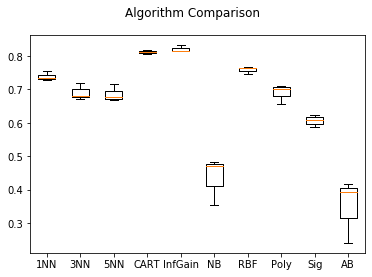

In [86]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()